### pip install & import

In [124]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.models import load_model

# 데이터 준비

### 최종 데이터 불러오기
* movie_final_분류 : 전국 관객수 80만명 초과, 전국 스크린수 50개 초과   

In [2]:
movie_final_분류 = pd.read_csv('../3_merge_top300/movie_final_cls.csv',encoding='utf-8')

### 스케일링


In [3]:
# 전국 스크린수와 총 관객수를 스케일링: RobustScaler() 사용
# 객체생성
robust_scaler = RobustScaler()

# *** '전국 스크린수'와 '총 관객수' 컬럼을 스케일링 ***
A_n = robust_scaler.fit_transform(movie_final_분류['전국 스크린수'].values.reshape(-1,1))
movie_final_분류.insert(0, '전국 스크린수_scaled', A_n)
movie_final_분류.drop(['전국 스크린수'], axis=1, inplace=True)

A_n1 = robust_scaler.fit_transform(movie_final_분류['총 관객수'].values.reshape(-1,1))
movie_final_분류.insert(0, '총 관객수_scaled', A_n1)
movie_final_분류.drop(['총 관객수'], axis=1, inplace=True)

# 변경이 잘 되었는지 확인
movie_final_분류.columns

Index(['총 관객수_scaled', '전국 스크린수_scaled', 'Unnamed: 0', '순번', '영화명', '감독',
       '배급사', '개봉일', '영화형태', '국적', '전국 매출액', '전국 관객수', '서울 매출액', '서울 관객수',
       '장르', '등급', '영화구분', '연도', '월', '계절', '코로나', '출연', '평점', '감독_흥행',
       '배급사_흥행', '주연배우_흥행'],
      dtype='object')

### 라벨링

#### 1) 인풋 데이터 라벨링


In [4]:
# 명목형 자료들을 라벨링: LabelEncoder() 사용

le_form = LabelEncoder()
le_nation = LabelEncoder()
le_genre = LabelEncoder()
le_rating = LabelEncoder()
le_class = LabelEncoder()
le_season = LabelEncoder()
le_year = LabelEncoder()

movie_labels = movie_final_분류.copy()
movie_labels['영화형태'] = le_form.fit_transform(movie_final_분류['영화형태'])
movie_labels['국적'] = le_nation.fit_transform(movie_final_분류['국적'])
movie_labels['장르'] = le_genre.fit_transform(movie_final_분류['장르'])
movie_labels['등급'] = le_rating.fit_transform(movie_final_분류['등급'])
movie_labels['영화구분'] = le_class.fit_transform(movie_final_분류['영화구분'])
movie_labels['계절'] = le_season.fit_transform(movie_final_분류['계절'])
movie_labels['연도'] = le_year.fit_transform(movie_final_분류['연도'])
movie_labels.drop(['Unnamed: 0'],axis=1,inplace=True)
movie_labels.columns


Index(['총 관객수_scaled', '전국 스크린수_scaled', '순번', '영화명', '감독', '배급사', '개봉일',
       '영화형태', '국적', '전국 매출액', '전국 관객수', '서울 매출액', '서울 관객수', '장르', '등급',
       '영화구분', '연도', '월', '계절', '코로나', '출연', '평점', '감독_흥행', '배급사_흥행',
       '주연배우_흥행'],
      dtype='object')

#### 2) 타겟 데이터 라벨링

In [5]:
# target 데이터 라벨링
# 전국 관객수 기준, [100만미만/100만/150만/300만/500만]으로 나누어 라벨링

movie_labels['분류클래스'] = np.where((movie_labels['전국 관객수'].values<1000000), 0, 
                                 np.where((movie_labels['전국 관객수'].values>=1000000) & (movie_labels['전국 관객수'].values<1500000), 1,
                                          np.where((movie_labels['전국 관객수'].values>=1500000) & (movie_labels['전국 관객수'].values<3000000), 2,
                                                   np.where((movie_labels['전국 관객수'].values>=3000000) & (movie_labels['전국 관객수'].values<5000000), 3, 4))))

classes = sorted(movie_labels['분류클래스'].unique())
print(classes)
for i in classes:
    print(i, len(movie_labels[movie_labels['분류클래스']==i]))

[0, 1, 2, 3, 4]
0 100
1 149
2 249
3 109
4 101


### 데이터 및 변수 정리


#### 1) 독립 및 종속 변수 선언

In [6]:
# 사용하는 컬럼만 독립변수와 종속변수에 할당
독립 = movie_labels[['장르', '등급', '감독_흥행','총 관객수_scaled',
               '배급사_흥행','주연배우_흥행','계절', '전국 스크린수_scaled','연도','코로나']].copy()

종속 = movie_labels[['분류클래스']].copy()

display(독립.info())
print()
display(종속.describe().round())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   장르              708 non-null    int32  
 1   등급              708 non-null    int32  
 2   감독_흥행           708 non-null    int64  
 3   총 관객수_scaled    708 non-null    float64
 4   배급사_흥행          708 non-null    int64  
 5   주연배우_흥행         708 non-null    int64  
 6   계절              708 non-null    int32  
 7   전국 스크린수_scaled  708 non-null    float64
 8   연도              708 non-null    int64  
 9   코로나             708 non-null    int64  
dtypes: float64(2), int32(3), int64(5)
memory usage: 47.1 KB


None

,분류클래스
count,708.0
mean,2.0
std,1.0
min,0.0
25%,1.0
50%,2.0
75%,3.0
max,4.0


#### 2) train, validation, test용 데이터 나누기

In [113]:
# 1. train 데이터(80%)와 test 데이터(20%)로 나누기
train_input, test_input, train_target, test_target = train_test_split(독립, 종속, test_size=0.05, random_state=31)
print(len(train_input), len(test_input))

672 36


In [114]:
# 2. train 데이터를 train 데이터(80%*80%)와 val 데이터(80%*20%)로 나누기
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.10, random_state=31)
print(len(train_input), len(val_input), len(test_input))

604 68 36


In [115]:
# 클래스 별로 고루 분배되었는지 확인
# 분배 잘 안되었으면 split 1, 2 다시 실행

classes = sorted(train_target['분류클래스'].unique())
for i in classes:
    print(i, len(train_target[train_target['분류클래스']==i]))
print()

for i in classes:
    print(i, len(val_target[val_target['분류클래스']==i]))
print()

for i in classes:
    print(i, len(test_target[test_target['분류클래스']==i]))

0 85
1 122
2 218
3 93
4 86

0 8
1 18
2 22
3 11
4 9

0 7
1 9
2 9
3 5
4 6


In [116]:
# 확인 완료 되었으면 target 데이터 flatten
train_target, val_target, test_target = train_target.to_numpy().flatten(), val_target.to_numpy().flatten(), test_target.to_numpy().flatten()

# 모델 구조 만들기
#### 1) 하이퍼파라미터 튜닝

In [117]:
# 모델 생성 함수
def create_model(learning_rate=0.01, num_layers=4, units=128):
    X = Input(shape=(train_input.shape[1],))
    H = Dense(units, activation = 'relu')(X)
    H = Dense(64, activation = 'relu')(H)
    H = Dense(32, activation = 'relu')(H)
    H = Dense(16, activation = 'relu')(H)
    Y = Dense(5, activation='softmax')(H)
    model = Model(X, Y)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Keras Classifier 생성
model = KerasClassifier(build_fn=create_model, epochs=200, batch_size=32, verbose=0)

# 하이퍼파라미터 탐색 범위
param_dist = {
    'learning_rate': np.arange(0.001, 0.01, 0.001),
    'num_layers': [2, 3, 4, 5],
    'units': [32, 64, 128, 256]
}

# 랜덤 서치 객체 생성
search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=3, n_iter=20, n_jobs=3, verbose=1)

# 랜덤 서치 수행
search_results = search.fit(train_input, train_target)

# 결과 출력
print('Best Score:', search_results.best_score_)
print('Best Params:', search_results.best_params_)

C:\Users\Playdata\AppData\Local\Temp\ipykernel_13028\1072662922.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=200, batch_size=32, verbose=0)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Score: 0.3974188466866811
Best Params: {'units': 256, 'num_layers': 5, 'learning_rate': 0.006}


#### (2) 최적의 하이퍼파라미터 적용하여 모델 생성 

In [151]:
X = tf.keras.layers.Input(shape=[len(train_input.columns)])

H = tf.keras.layers.Dense(256, activation=tf.nn.relu)(X)
H = tf.keras.layers.Dense(128, activation=tf.nn.relu)(H)
H = tf.keras.layers.Dense(64, activation=tf.nn.relu)(H)
H = tf.keras.layers.Dense(32, activation=tf.nn.relu)(H)

Y = tf.keras.layers.Dense(5, activation='softmax')(H)
model = tf.keras.models.Model(X,Y)

adam = tf.keras.optimizers.Adam(learning_rate=0.006)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


# 모델 학습시키기

### 클래스별 가중치 적용하여 딥러닝 학습 실행
클래스별 편향된 분포를 조정하기 위해 클래스별 가중치를 계산한다.

In [152]:
# 레이블 클래스 빈도수 계산
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.array([0, 1, 2, 3, 4]), y=train_target)

# 가중치 딕셔너리 생성
class_weight_dict = dict(enumerate(class_weights))

# 모델 학습 시 class_weight 파라미터에 가중치 딕셔너리 전달
history = model.fit(train_input, train_target, epochs=500, batch_size=32, class_weight=class_weight_dict, validation_data=(val_input, val_target))

Epoch 1/500
19/19 [==============================] - 1s 16ms/step - loss: 1.7748 - accuracy: 0.2070 - val_loss: 1.5719 - val_accuracy: 0.1912
Epoch 2/500
19/19 [==============================] - 0s 7ms/step - loss: 1.5772 - accuracy: 0.2682 - val_loss: 1.5691 - val_accuracy: 0.2059
Epoch 3/500
19/19 [==============================] - 0s 6ms/step - loss: 1.5544 - accuracy: 0.2417 - val_loss: 1.5407 - val_accuracy: 0.3676
Epoch 4/500
19/19 [==============================] - 0s 7ms/step - loss: 1.4981 - accuracy: 0.2599 - val_loss: 1.5823 - val_accuracy: 0.2353
Epoch 5/500
19/19 [==============================] - 0s 7ms/step - loss: 1.4864 - accuracy: 0.2997 - val_loss: 1.4824 - val_accuracy: 0.3382
Epoch 6/500
19/19 [==============================] - 0s 7ms/step - loss: 1.4491 - accuracy: 0.2666 - val_loss: 1.5445 - val_accuracy: 0.2941
Epoch 7/500
19/19 [==============================] - 0s 6ms/step - loss: 1.3879 - accuracy: 0.3609 - val_loss: 1.5340 - val_accuracy: 0.2941
Epoch 8/500


### epoch에 따른 accuracy 변화 그래프 확인

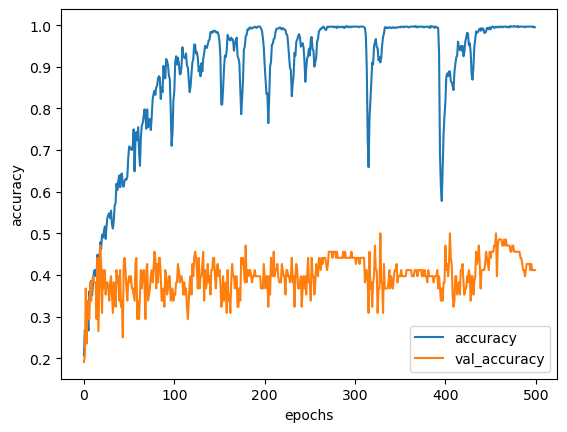

In [153]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

### 모델 평가
데이터 대부분이 분포되어 있는 클래스 0을 제외하고, 나머지 데이터를 가지고 평가

In [154]:
# 클래스가 1 이상에 해당하는 데이터만 t_target에 할당
# 해당 인덱스의 input 데이터도 t_input에 할당

t_target_index = pd.DataFrame(test_target)[test_target>=1].index
t_target = test_target[test_target>=1]
t_input = test_input.reset_index(drop=True)
t_input = t_input.loc[t_target_index]

model.evaluate(t_input, t_target)

1/1 [==============================] - 0s 24ms/step - loss: 5.7947 - accuracy: 0.5172


[5.794691562652588, 0.517241358757019]

#### test 세트로 모델 predict 수행

In [155]:
a = model.predict(test_input)
[np.where(i == max(i))[0][0] for i in a][:10]

[4, 4, 2, 2, 0, 2, 0, 0, 1, 2]

In [156]:
list(test_target[:10])

[4, 4, 3, 2, 2, 2, 0, 1, 0, 2]

### 모델 저장

In [157]:
model.save('cls_model.h5')